In [53]:
# !pip install workalendar
# !pip install openpyxl

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

### Data preparation

In [55]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2024-06-18,16698,500,450,225,85,3,90
2024-06-17,16625,592,420,277,88,3,96
2024-06-16,15286,528,237,319,51,5,55
2024-06-15,17654,599,224,353,56,2,64
2024-06-14,17103,556,424,237,68,5,73
...,...,...,...,...,...,...,...
2022-06-19,16747,739,197,440,59,3,68
2022-06-18,18769,708,258,404,71,6,72
2022-06-17,18299,708,345,398,76,10,83


In [56]:
columns = df.columns
for col in columns:
  df[col] = df[col].astype(int)

# Initializing the Poland calendar, adding is_weekend column, is_holiday
cal = Poland()
df['is_weekend'] = df.index.weekday >= 4
df['is_holiday'] = df.index.to_series().apply(lambda x: cal.is_holiday(x))
df.head()

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,is_weekend,is_holiday
Date,,,,,,,,,
2024-06-18,16698,500,450,225,85,3,90,False,False
2024-06-17,16625,592,420,277,88,3,96,False,False
2024-06-16,15286,528,237,319,51,5,55,True,False
2024-06-15,17654,599,224,353,56,2,64,True,False
2024-06-14,17103,556,424,237,68,5,73,True,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


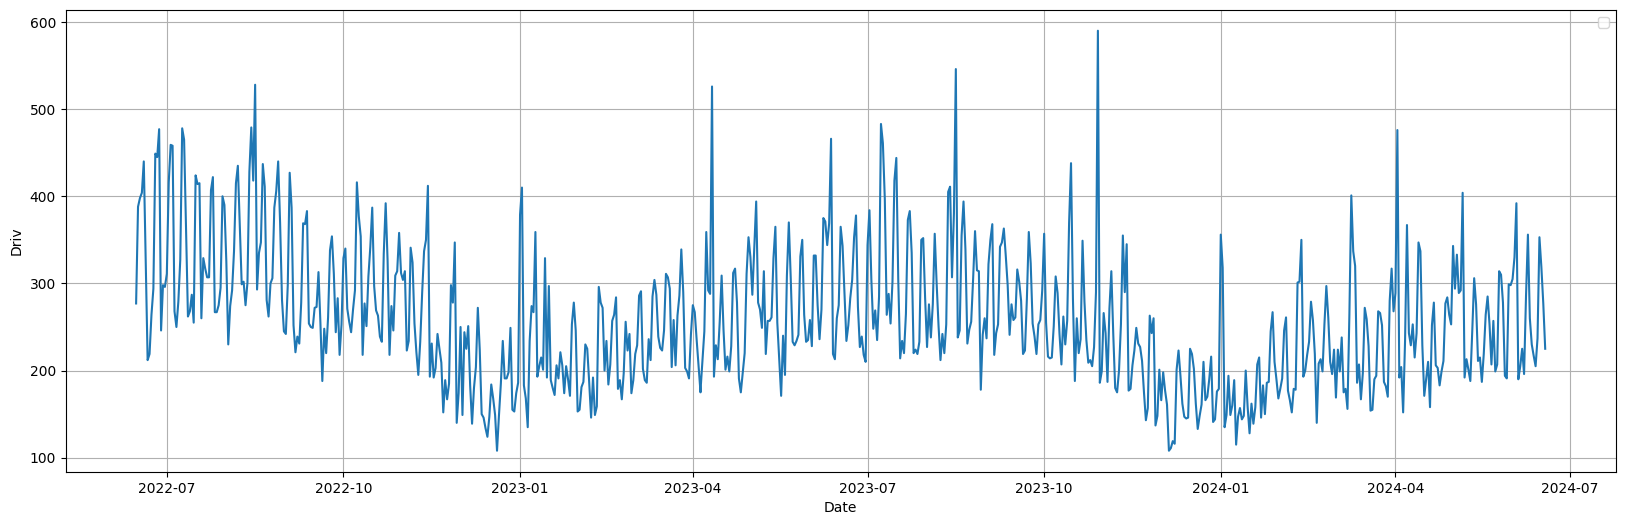

In [59]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]

plt.plot(df.index, df["Drivers_under_the_influence_of_alcohol"])
plt.xlabel('Date')
plt.ylabel('Driv')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

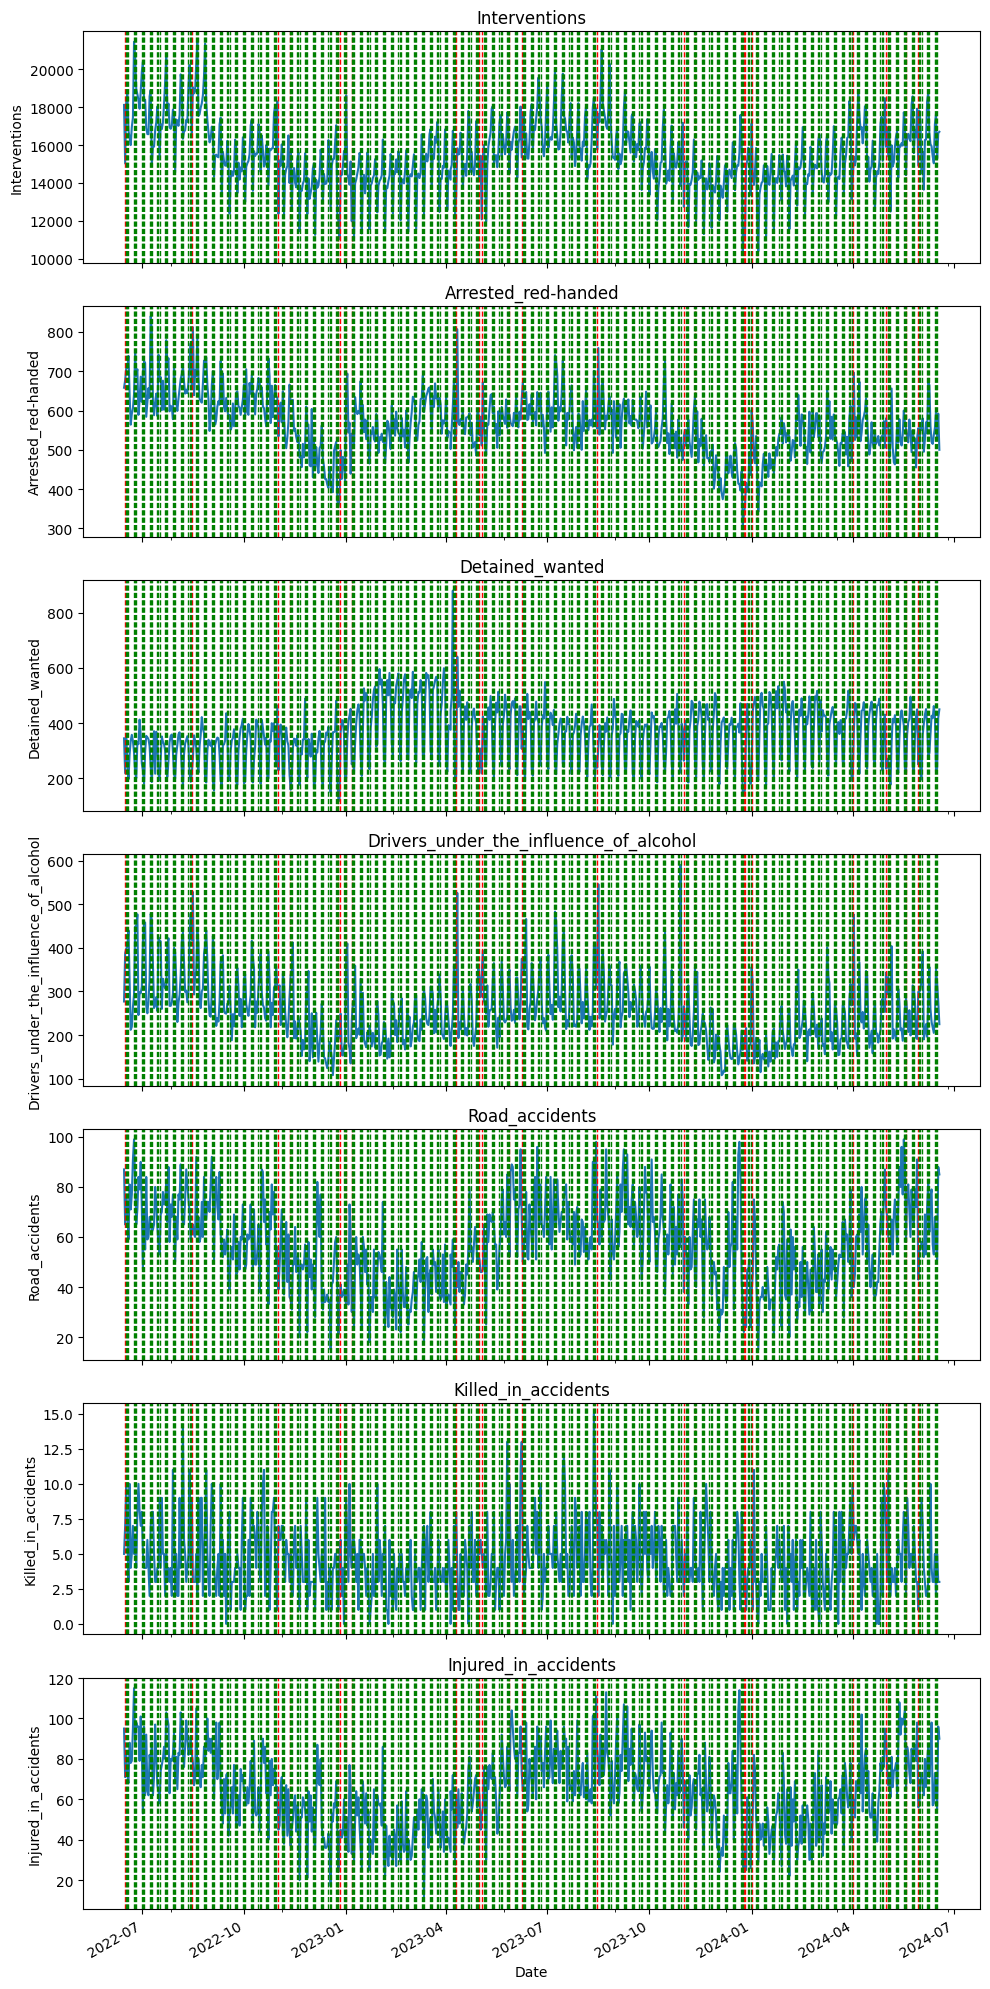

In [58]:
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
holidays = df.index[df['is_holiday'] == True]
weekends = df.index[df['is_weekend'] == True]

for i, col in enumerate(columns):
    df[col].plot(ax=axes[i], title=col.strip(), legend=False)
    axes[i].set_ylabel(col.strip())
    
    # Plot vertical lines on holidays
    for holiday in holidays:
        axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
    for weekend in weekends:
        axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

plt.tight_layout()
plt.show()